# Making bodies move

For many applications we wish to specify the motion of a body. Motions
come in two forms: rigid-body motions, in which the body moves as a rigid
unit; and deformations, in which the surface's shape is altered. These
two types of motions can also be combined.

In [1]:
using RigidBodyTools
using Plots

Before we get started, let's define a macro that can help us
animate the motions we will be creating

In [2]:
macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, motion_state(bc,$m)
            x = copy(x0)
            @gif for t in t0:$dt:t0+$tmax
                global x += motion_velocity(bc,$m,t)*$dt
                update_body!(bc,x,$m)
                plot(bc,xlim=$xlim,ylim=$ylim)
            end every 5
        end)
end

@animate_motion (macro with 1 method)

## Rigid-body motions
We will start with rigid-body motions. These are created with the `RigidBodyMotion`
constructor. For these, we have a variety
of *kinematics* classes, which allow us to constrain the motion in particular
ways. The most basic of these is just constant translational and rotational motion:

In [3]:
m = RigidBodyMotion((1.0,2.0),π/2)

Rigid Body Motion:
  Constant rotation (żp = 1.0 + 2.0im, α̇ = 1.5707963267948966) 
   about z̃p = 0.0 + 0.0im (in comoving coordinates) 

Let's demonstrate this on a rectangular body

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_NGZ6zmv0vQ.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_NGZ6zmv0vQ.gif")
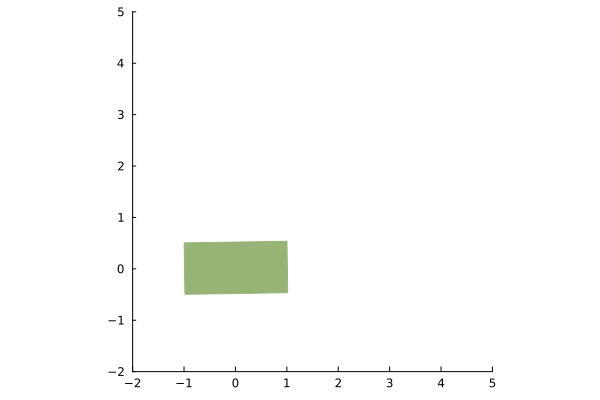

In [4]:
b = Rectangle(1.0,0.5,0.02)
@animate_motion b m 0.01 2.0 (-2,5) (-2,5)

Notice that the animation macro makes use of three key functions:
`motion_state`, `motion_velocity`, and `update_body!`. These are used
frequently:
- `motion_state(b,m)` returns the state vector that describes the body motion
- `motion_velocity(b,m,t)` returns the rate of change of the state vector at time `t`
- `update_body!(b,x,m)` updates the body with the state vector `x`.

There is one more function that is useful for some downstream application:
`surface_velocity!(u,v,b,m,t)` provides the surface velocity components `u` and `v`
*in the inertial coordinate system, at the midpoints of the surface segments*.

We can also set a different center of rotation with the `pivot` keyword argument.
Here, we remove the translation and set a center of rotation at (0,-1).

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_3KXY5urevS.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_3KXY5urevS.gif")
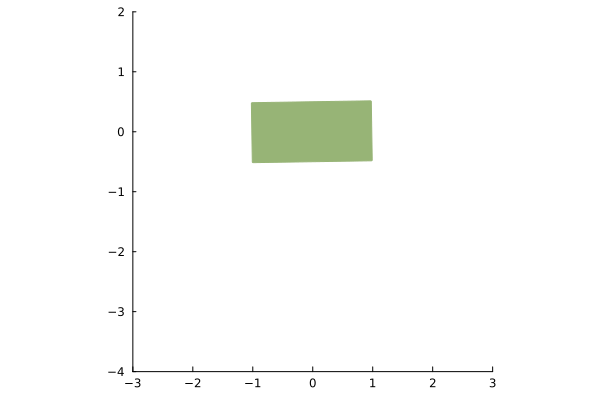

In [5]:
m = RigidBodyMotion((0.0,0.0),π/2;pivot = (0.0,-1.0))
@animate_motion b m 0.01 4.0 (-3,3) (-4,2)

Let's try something more interesting. We will use a pitch-up maneuver on a
thick plate. This pitches up about the leading edge to 45 degrees, at a pitch
rate of 0.2 (the ratio $\dot{\alpha}c/2U_0$), where $c$ is the length of the
plate. The forward velocity $U_0$ is set to 1.

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_nk5GXMFuVm.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_nk5GXMFuVm.gif")
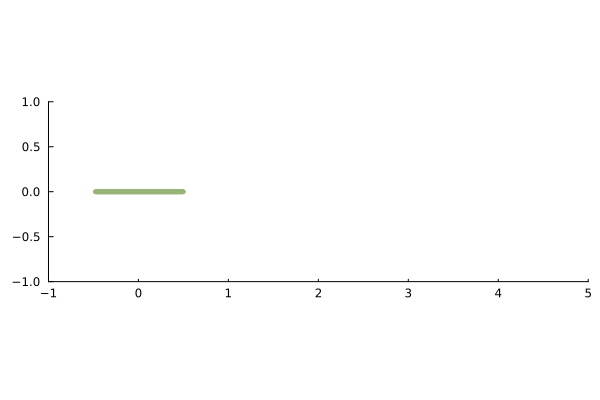

In [6]:
kin = Pitchup(1.0,0.5,0.2,0.0,0.5,π/4)
m = RigidBodyMotion(kin)
b = ThickPlate(1.0,0.05,0.02)
@animate_motion b m 0.01 3.0 (-1,5) (-1,1)

There are a number of other types of kinematics, particularly those
with oscillatory behavior: `OscillationX`, `OscillationY`, `RotationalOscillation`,
`OscillationXY`, `PitchHeave`, `Oscillation`. Each one is documented.

## Deforming bodies
For deforming bodies, we specify the motion of the surface directly. This
deformation velocity is expressed in the coordinate system attached to the
body, rather than our inertial coordinate system. This enables the
motion to be easily superposed with the rigid-body motion described above.

It is also important to note that the motion is applied **to the endpoints**
of the surface segments. The midpoints are then constructed from the
updated endpoints.
Let's see an example. We will create an oscillatory deformation of a circle.
We create the motion by creating functions for each component of velocity.

In [7]:
ufcn(x,y,t) = 0.25*x*y*cos(t)
vfcn(x,y,t) = 0.25*(x^2-y^2)*cos(t)
m = DeformationMotion(ufcn,vfcn)

DeformationMotion{typeof(Main.var"##718".ufcn), typeof(Main.var"##718".vfcn)}(Main.var"##718".ufcn, Main.var"##718".vfcn)

Now create the body and visualize the motion

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_NklKZ4JwTW.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_NklKZ4JwTW.gif")
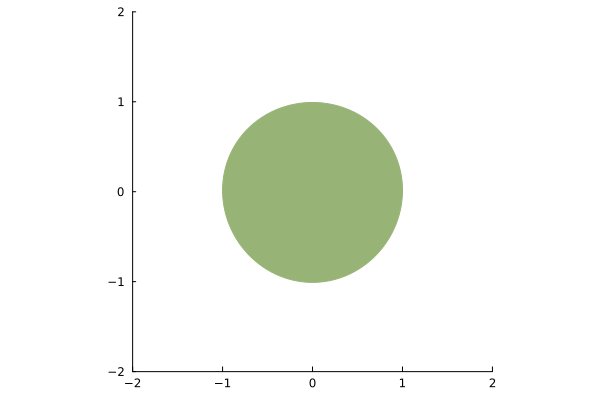

In [8]:
b = Circle(1.0,0.02)
@animate_motion b m π/100 4π (-2,2) (-2,2)

There is a more basic type of deformation motion: `ConstantDeformationMotion`,
which is not time varying, but simply a constant vector for each surface
(end) point. Let's make the circle expand radially at constant velocity

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_FGXI3Mrivo.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_FGXI3Mrivo.gif")
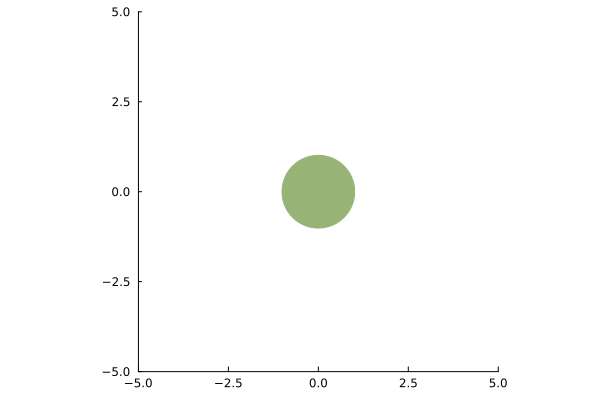

In [9]:
u = copy(b.x̃end)
v = copy(b.ỹend)
m = ConstantDeformationMotion(u,v)
@animate_motion b m 0.01 2.0 (-5,5) (-5,5)

## Rigid and deforming motions
We can easily combine rigid and deforming motions with the use of `RigidAndDeformingMotion`.
Let's make a square oscillate in rotation and undergo oscillatory deformation:

In [10]:
b = Square(1.0,0.02)

Closed polygon with 4 vertices and 400 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Here is the rotational oscillation, with frequency $\Omega$.

In [11]:
Ω = 1.0
kin = RotationalOscillation(Ω,π/4,0.0)
mrig = RigidBodyMotion(kin)

Rigid Body Motion:
  Oscillatory kinematics with
     Steady velocity U = (0.0,0.0)
     Ref angle α₀ = 0.0
     Mean rotation rate α̇₀ = 0.0
     Pitch axis (rel. to centroid) a = (0.0,0.0)
     Frequency Ω = 1.0
     x amplitude Ax, phase lag ϕx = (0.0, 0.0)
     y amplitude Ay, phase lag ϕy = (0.0, 0.0)
     α amplitude Δα, phase lag ϕα = (0.7853981633974483, 0.0)


Here is the deformation.

In [12]:
ufcn(x,y,t) = 0.25*(x^2+y^2)*y*cos(Ω*t)
vfcn(x,y,t) = -0.25*(x^2+y^2)*x*cos(Ω*t)
mdef = DeformationMotion(ufcn,vfcn)

DeformationMotion{typeof(Main.var"##718".ufcn), typeof(Main.var"##718".vfcn)}(Main.var"##718".ufcn, Main.var"##718".vfcn)

Now put them together with `RigidAndDeformingMotion`, and animate it:

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_nancBm5SfC.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_nancBm5SfC.gif")
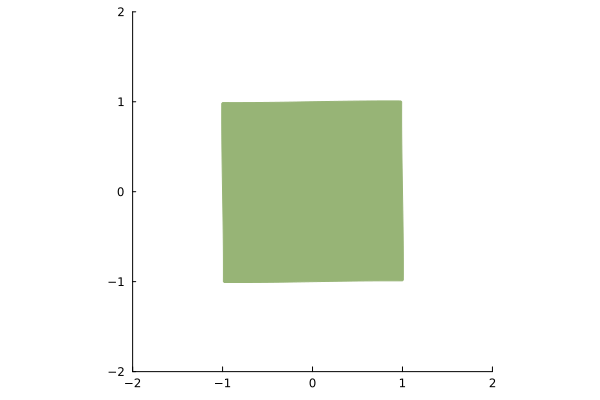

In [13]:
m = RigidAndDeformingMotion(mrig,mdef)
@animate_motion b m π/100 4π (-2,2) (-2,2)

Sometimes it is helpful to know the maximum velocity that a given
motion will produce. For this, we can use the function `maxvelocity`.
This also tells us where it will occur on the body, and at what time.

In [14]:
umax, i, t = maxvelocity(b,m)

(0.5357831484256822, 40, 0.0)

## Defining new motions
It is straightforward to define new types of deformation motion that don't fit into the framework
shown here. We need only do two things:
- Create a type as a subtype of `AbstractDeformationMotion`.
- Extend the function `RigidBodyTools.motion_velocity(b,m,t)` for your
  new motion type, so that it returns a concatenated vector of
  the surface segment endpoint velocity components (in body coordinate system).

Let's demonstrate this with an example in which we specify a motion in which only
the top of a rectangle will deform. For this, we make use of the `side`
field in the `Polygon` type: each entry in `side` describes the range of indices
of segment endpoints on each side (including the first vertex).

In [15]:
struct TopMotion{UT} <: AbstractDeformationMotion
    vtop :: UT
end

function RigidBodyTools.motion_velocity(b::Polygon,m::TopMotion,t::Real)

    u, v = zero(b.x̃end), zero(b.ỹend)
    top = b.side[3]
    v[top] .= m.vtop.(b.x̃end[top],b.ỹend[top],t)
    return vcat(u,v)
end

Let's apply a deformation function and see it work:

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_hGxudmNA3A.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_hGxudmNA3A.gif")
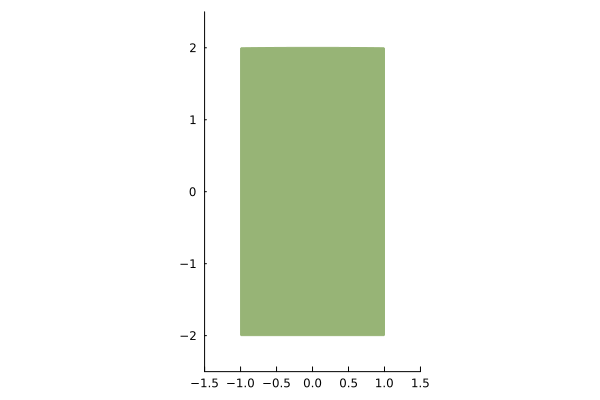

In [16]:
b = Rectangle(1.0,2.0,0.02)
vfcn(x,y,t) = 0.2*(1-x^2)*cos(t)
m = TopMotion(vfcn)

@animate_motion b m π/100 4π (-1.5,1.5) (-2.5,2.5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*